In [1]:
# import yfinance as yf

# # Define the ticker symbol
# ticker_symbol = 'AAPL'

# # Get the data for the ticker symbol
# stock = yf.Ticker(ticker_symbol)

# # Get historical market data
# hist = stock.history(period="max")

# hist.to_csv('AAPL.CSV')

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf

keras = tf.keras

In [3]:
stk = pd.read_csv('AAPL.CSV')

# Change date column to datetime type
stk['Date'] = stk['Date'].str.split(' ').str[0]
stk['date'] = pd.to_datetime(stk['Date'])

In [4]:
stk.tail(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,date
10904,2024-03-15,170.938152,172.386185,170.059339,172.386185,121664700,0.0,0,2024-03-15
10905,2024-03-18,175.332196,177.469296,173.284969,173.484695,75604200,0.0,0,2024-03-18
10906,2024-03-19,174.103843,176.370773,172.795620,175.841492,55215200,0.0,0,2024-03-19
10907,2024-03-20,175.481992,178.427994,174.852841,178.427994,53423100,0.0,0,2024-03-20
10908,2024-03-21,176.810193,177.249599,170.608598,171.137878,106181300,0.0,0,2024-03-21
10909,2024-03-22,171.527346,172.815607,169.829652,172.046646,71106600,0.0,0,2024-03-22
10910,2024-03-25,170.338972,171.707111,169.220479,170.618591,54288300,0.0,0,2024-03-25
10911,2024-03-26,169.769734,171.187808,169.350304,169.480133,57388400,0.0,0,2024-03-26
10912,2024-03-27,170.179175,173.364857,169.879579,173.075241,60273300,0.0,0,2024-03-27
10913,2024-03-28,171.517365,171.996711,170.279039,171.247726,65672700,0.0,0,2024-03-28


In [5]:
stk.dropna(inplace=True)

In [6]:
series = stk['Close']

# Create train data set
train_split_date = '2015-12-31'
train_split_index = np.where(stk.Date == train_split_date)[0][0]
x_train = stk.loc[stk['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2018-01-02'
test_split_index = np.where(stk.Date == test_split_date)[0][0]
x_test = stk.loc[stk['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = stk.loc[(stk['Date'] < test_split_date) & (stk['Date'] > train_split_date)]['Close']

8840 8841 9343 9344 10913


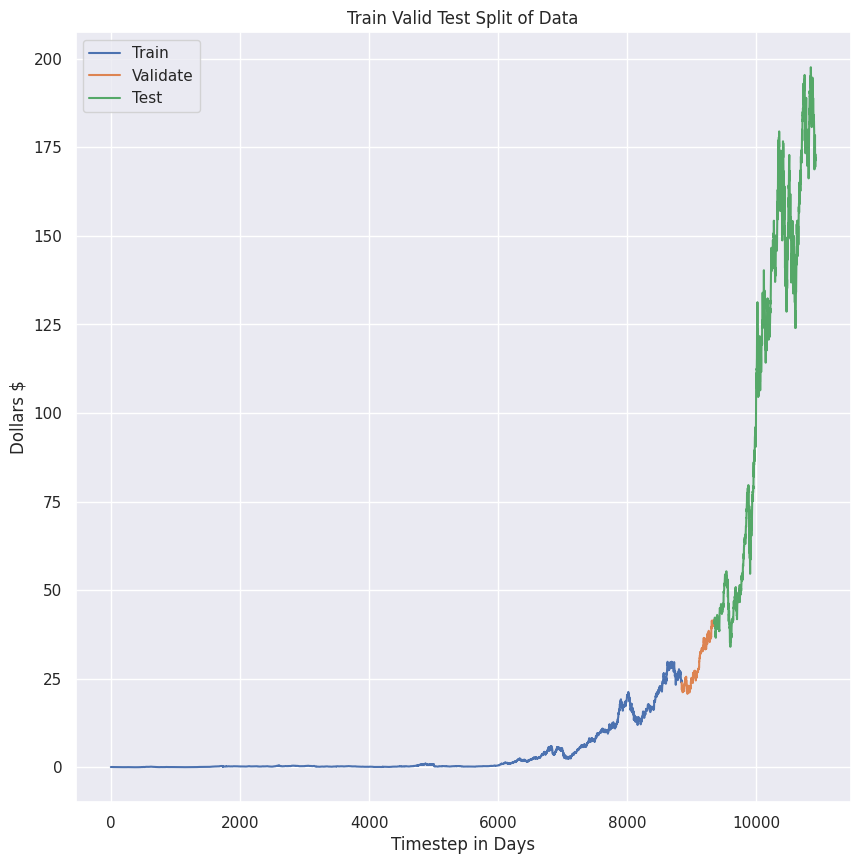

In [7]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [8]:
def test_stationarity(series):
    # Determining rolling statistics
    rolmean = series.rolling(window=12).mean()
    rolstd = series.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(series, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

    # Perform Augmented Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

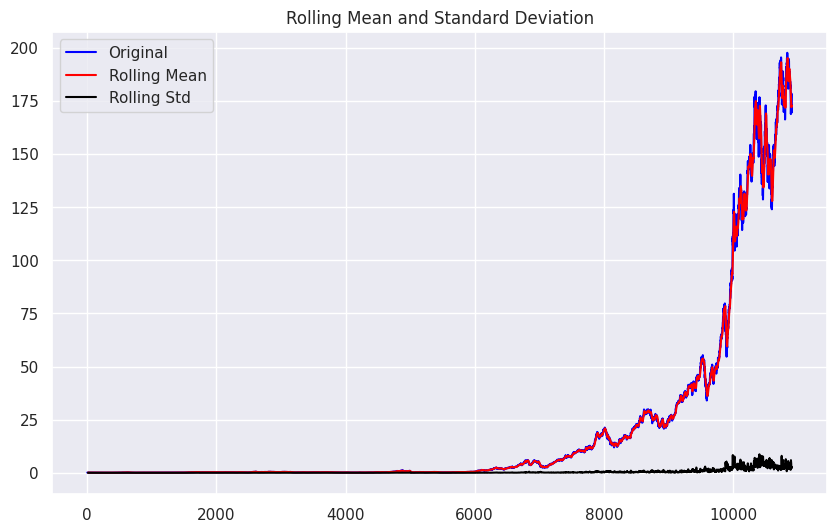

Results of Dickey-Fuller Test:
Test Statistic                     2.498235
p-value                            0.999049
#Lags Used                        39.000000
Number of Observations Used    10874.000000
Critical Value (1%)               -3.430952
Critical Value (5%)               -2.861806
Critical Value (10%)              -2.566911
dtype: float64


In [9]:
test_stationarity(series)

p-value > 0.05 -> Non-Stationary

In [10]:
# Get the difference of each Adj Close point
close_diff_1 = series.diff()
close_diff_1.dropna(inplace=True)

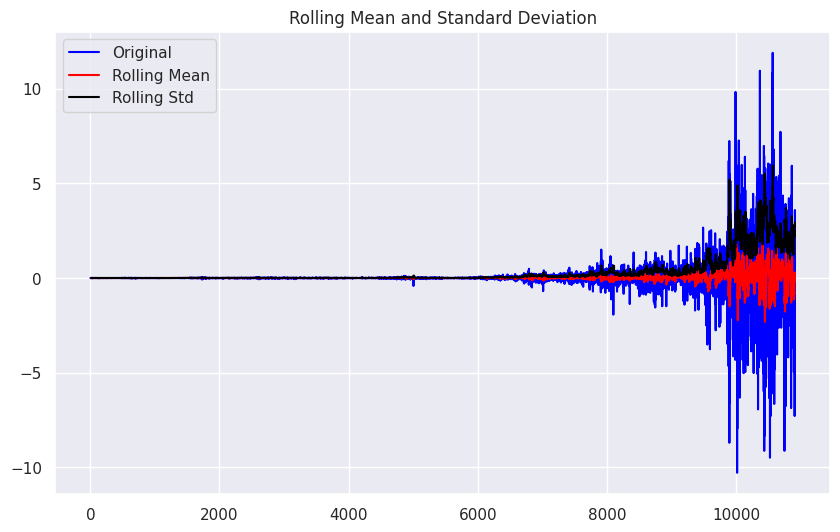

Results of Dickey-Fuller Test:
Test Statistic                -1.811075e+01
p-value                        2.537864e-30
#Lags Used                     3.900000e+01
Number of Observations Used    1.087300e+04
Critical Value (1%)           -3.430952e+00
Critical Value (5%)           -2.861806e+00
Critical Value (10%)          -2.566912e+00
dtype: float64


In [11]:
test_stationarity(close_diff_1)

p-value < 0.05 -> Stationary

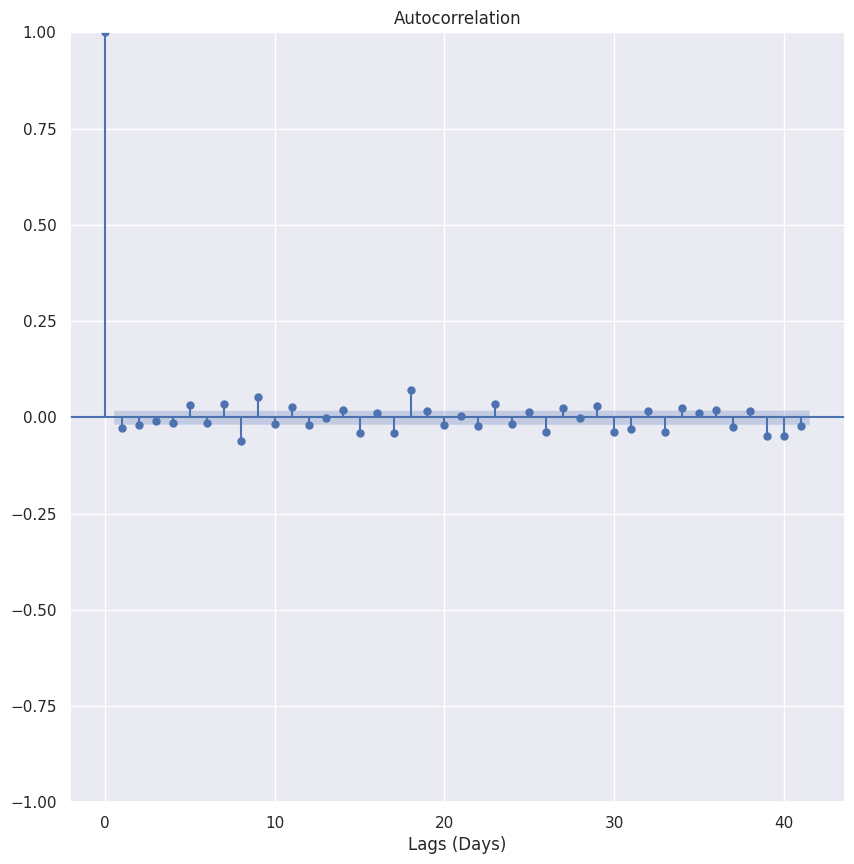

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

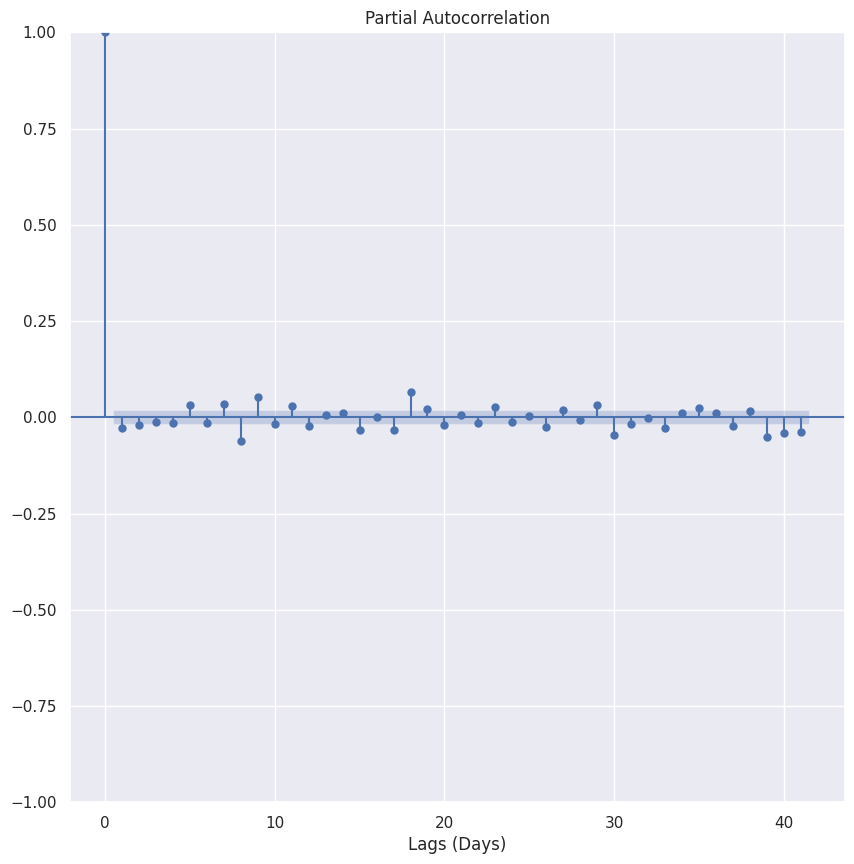

In [13]:
plot_pacf(close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
stk_arima = ARIMA(x_train, order=(1,1,1))
stk_arima_fit = stk_arima.fit()
print(stk_arima_fit.summary())

In [ ]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)

MAE_error = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

In [18]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[23.894574382083718,
 39.62831578532623,
 40.26681469406879,
 40.56851343377237,
 41.24982393548998]

In [19]:
#save model
model_fit.save('arima.pkl')

# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('arima.pkl')

In [20]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
print(arima_mae)

1.5146266942672841


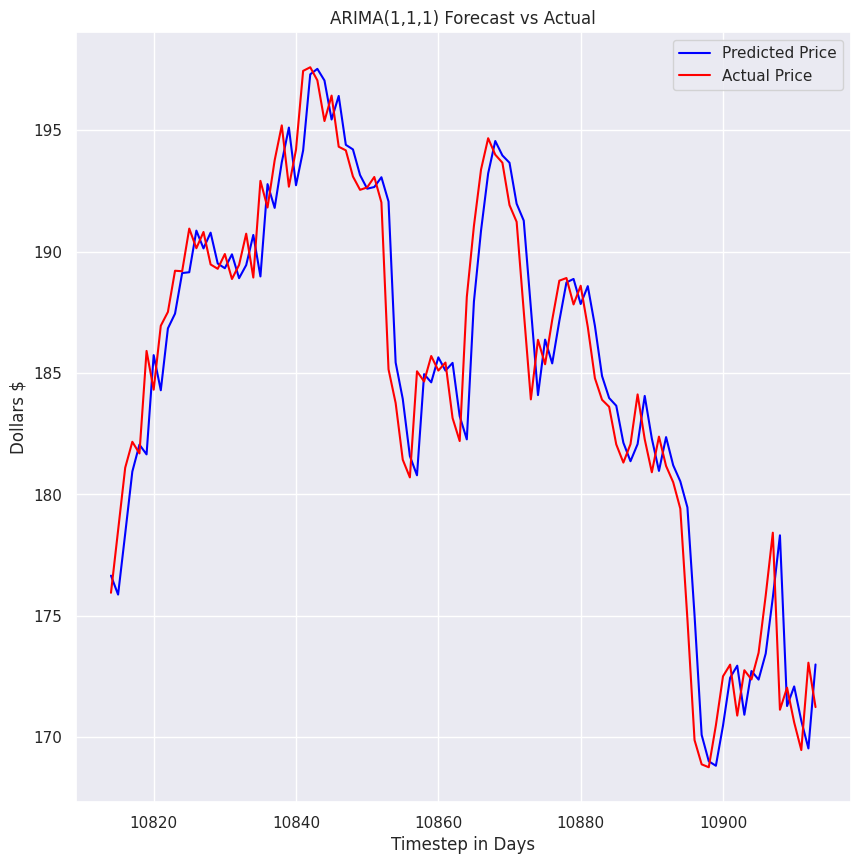

<Figure size 1000x600 with 0 Axes>

In [24]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-100:], model_predictions[-100:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-100:], x_test[-100:], color='red', label='Actual Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()